
# 🩺 医学因果推断 · 阶段 0（可运行 Notebook）
> 目标：完成环境准备、快速数据加载与基础探索（EDA），为后续因果推断实战打底。  
> 语言：Python  
> 适用方向：医学研究（RWD / EMR / 生存分析前置准备）

**建议学习路径**
1. 环境与依赖检查（含备选安装命令）  
2. 加载内置教学数据（DoWhy Lalonde）并做入门级探索  
3. 加载医学公共数据（UCI Heart Disease）并做入门级探索  
4. EDA 关注点（因果视角）与下一步路线



## 0. 环境与依赖检查（首次运行必看）

> 本单元不会强制联网安装依赖，而是先检查环境。  
> 如果缺包，请**在你本地的终端/Anaconda Prompt**中运行给出的 pip/conda 命令安装。


In [1]:

import sys, platform, importlib

core_libs = [
    "pandas", "numpy", "matplotlib", "scikit_learn", "statsmodels",
    "dowhy", "econml", "causalml"
]

def check(lib):
    try:
        if lib == "scikit_learn":
            import sklearn as m
        else:
            m = importlib.import_module(lib)
        ver = getattr(m, "__version__", "unknown")
        print(f"[OK] {lib} - {ver}")
        return True
    except Exception as e:
        print(f"[MISSING] {lib} - {e}")
        return False

print("Python:", sys.version.split()[0], "| Platform:", platform.platform())
print("\n== Dependency Check ==")
missing = []
for lib in core_libs:
    ok = check(lib)
    if not ok:
        missing.append(lib)

if missing:
    print("\n== You seem to be missing the following packages ==")
    print(missing)
else:
    print("\nGreat! All recommended packages are available.")


Python: 3.11.1 | Platform: Linux-5.4.241-1-tlinux4-0017.7-x86_64-with-glibc2.31

== Dependency Check ==


[OK] pandas - 2.2.2
[OK] numpy - 1.26.4
[OK] matplotlib - 3.9.0
[OK] scikit_learn - 1.6.1
[OK] statsmodels - 0.14.5


/root/.pyenv/versions/3.11.1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[OK] dowhy - 0.13
[OK] econml - 0.16.0
[OK] causalml - unknown

Great! All recommended packages are available.



### 若缺包，请在终端手动安装

> 建议在**独立虚拟环境**中安装，避免与其他项目冲突。

**Conda 创建环境（推荐）**
```bash
conda create -n causal python=3.10 -y
conda activate causal
```

**使用 pip 安装（在已激活的环境中）**
```bash
pip install -U pip
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels dowhy econml causalml
```

> 注：`econml` 和 `causalml` 的编译依赖较多，Windows 环境推荐使用 Conda。若安装遇到困难，可优先保证 `pandas/numpy/matplotlib/scikit-learn/statsmodels/dowhy` 就能跑通本 Notebook 的主体内容。


In [2]:
# ! pip install seaborn scikit-learn statsmodels dowhy econml causalml
# ! pip show seaborn scikit-learn statsmodels dowhy econml causalml



## 1. 使用 DoWhy 内置数据（Lalonde）做“零门槛”上手

> 该数据集是因果推断教学经典案例（有**处理**与**对照**、有混杂变量），非常适合快速跑通流程。


In [3]:
import numpy as np
import pandas as pd
import random

# 固定随机种子
SEED = 2024
np.random.seed(SEED)
random.seed(SEED)

# 1) 加载 DoWhy 模拟数据
import dowhy.datasets as dwd

try:
    data = dwd.linear_dataset(
        beta=10,
        num_common_causes=5,
        num_instruments=1,
        num_samples=1000,
        treatment_is_binary=True,
        stddev_treatment_noise=1.0,
        stddev_outcome_noise=1.0
    )
    df_lalonde = data["df"]
except Exception as e:
    print("加载数据失败：", e)
    df_lalonde = None
    data = {}

# 2) 定义工具函数：把 str / list / tuple / None 统一成 list[str]
def to_name_list(x):
    if x is None:
        return []
    if isinstance(x, str):
        return [x]
    if isinstance(x, (list, tuple, pd.Index, np.ndarray)):
        return [str(i) for i in list(x)]
    return [str(x)]

# 3) 提取关键列名（兼容不同 dowhy 版本）
if df_lalonde is not None:
    treatment_col = data.get("treatment_name", "treatment")
    outcome_col = data.get("outcome_name", "y")
    common_causes = data.get("common_causes_names", [])
    instrument_names = data.get("instrument_names", [])
else:
    treatment_col = outcome_col = None
    common_causes = instrument_names = None

# 4) 规范化为 list 形式
treat_names = to_name_list(treatment_col)
outcome_names = to_name_list(outcome_col)
common_causes = to_name_list(common_causes)
instrument_names = to_name_list(instrument_names)

# 5) 检查关键列是否存在
if df_lalonde is not None:
    required_cols = treat_names + outcome_names + common_causes + instrument_names
    missing = [c for c in required_cols if c not in df_lalonde.columns]
    if missing:
        print("⚠️ 警告：以下列在数据集中未找到：", missing)
    else:
        print("✅ 关键列检查通过。")

# 6) 若处理/结果变量只有一个，降维为字符串
if len(treat_names) == 1:
    treatment_col = treat_names[0]
else:
    treatment_col = treat_names

if len(outcome_names) == 1:
    outcome_col = outcome_names[0]
else:
    outcome_col = outcome_names

# 7) 如果处理变量是布尔型，则转为 0/1
if df_lalonde is not None and isinstance(treatment_col, str):
    if df_lalonde[treatment_col].dtype == bool:
        df_lalonde[treatment_col] = df_lalonde[treatment_col].astype(int)

# 8) 打印确认
print("最终处理变量：", treatment_col)
print("最终结果变量：", outcome_col)
print("混杂变量：", common_causes)
print("工具变量：", instrument_names)

if df_lalonde is not None:
    display(df_lalonde.head())


✅ 关键列检查通过。
最终处理变量： v0
最终结果变量： y
混杂变量： ['W0', 'W1', 'W2', 'W3', 'W4']
工具变量： ['Z0']


,Z0,W0,W1,W2,W3,W4,v0,y
0,0.0,0.483714,-0.135177,-0.914301,1.080965,-0.952381,1,4.033577
1,1.0,0.137063,0.983696,0.819866,-0.817823,-0.324305,1,16.886770
2,0.0,-0.858017,2.566611,0.072401,-2.035820,-1.486844,0,0.566833
3,0.0,1.049793,-0.451322,-1.591785,-0.213825,0.039028,0,-7.404641
4,0.0,-2.026710,1.225232,-2.103466,-1.730085,-1.451951,0,-18.561388



### 1.1 快速了解数据结构


In [4]:

if df_lalonde is not None:
    print("形状:", df_lalonde.shape)
    display(df_lalonde.describe(include='all'))
    print("\n列说明：")
    print("treatment:", treatment_col, "| outcome:", outcome_col)
    print("common_causes:", common_causes)
    print("instruments:", instrument_names)
else:
    print("未能加载数据。请先安装并重试。")


形状: (1000, 8)


,Z0,W0,W1,W2,W3,W4,v0,y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.170000,0.205493,0.388452,-0.599037,-0.932116,-0.612125,0.302000,-2.748452
std,0.375821,1.046983,0.982451,0.980335,1.002143,1.016596,0.459355,11.434962
min,0.000000,-2.869912,-2.924304,-3.427878,-4.552896,-3.883657,0.000000,-34.157711
25%,0.000000,-0.548405,-0.291059,-1.288658,-1.634364,-1.281756,0.000000,-10.794254
50%,0.000000,0.205958,0.391214,-0.552635,-0.955432,-0.597408,0.000000,-3.811565
75%,0.000000,0.953268,1.064369,0.072619,-0.245930,0.064603,1.000000,5.032098
max,1.000000,3.766540,3.557954,2.501061,2.511709,2.709903,1.000000,32.209644



列说明：
treatment: v0 | outcome: y
common_causes: ['W0', 'W1', 'W2', 'W3', 'W4']
instruments: ['Z0']



### 1.2 因果视角的基础 EDA（不求花哨，只求有效）
- **目标**：检查治疗组与对照组在关键基线变量上的差异（是否平衡）  
- **方法**：绘制直方图/箱线图；计算**标准化差异（Standardized Mean Difference, SMD）**


治疗组 n = 302 | 对照组 n = 698


,variable,SMD
0,W0,0.208124
1,W1,0.457308
2,W2,0.345386
3,W3,0.994260
4,W4,0.392903


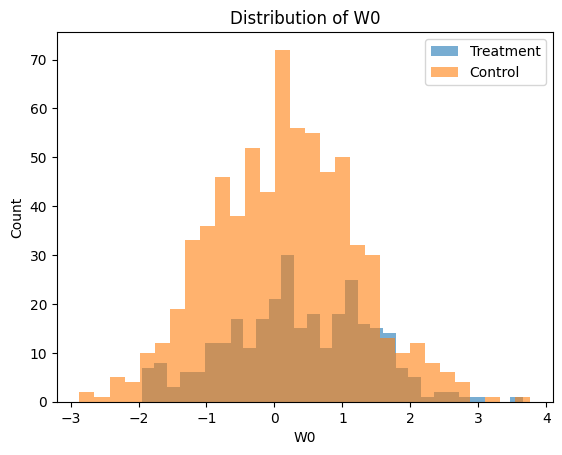

In [5]:

import matplotlib.pyplot as plt

def standardized_mean_diff(x_t, x_c):
    # SMD for continuous variable
    mu_t, mu_c = np.nanmean(x_t), np.nanmean(x_c)
    sd_pooled = np.sqrt((np.nanvar(x_t, ddof=1)+np.nanvar(x_c, ddof=1))/2)
    return (mu_t - mu_c) / (sd_pooled + 1e-12)

if df_lalonde is not None:
    tmask = df_lalonde[treatment_col] == 1
    cmask = df_lalonde[treatment_col] == 0

    print("治疗组 n =", int(tmask.sum()), "| 对照组 n =", int(cmask.sum()))

    smd_rows = []
    for v in common_causes:
        x_t, x_c = df_lalonde.loc[tmask, v], df_lalonde.loc[cmask, v]
        smd = standardized_mean_diff(x_t, x_c)
        smd_rows.append((v, smd))
    smd_df = pd.DataFrame(smd_rows, columns=["variable", "SMD"]).sort_values("variable")
    display(smd_df)

    # 对其中一个变量画直方图
    var_to_plot = common_causes[0]
    plt.figure()
    plt.hist(df_lalonde.loc[tmask, var_to_plot], alpha=0.6, label="Treatment", bins=30)
    plt.hist(df_lalonde.loc[cmask, var_to_plot], alpha=0.6, label="Control", bins=30)
    plt.xlabel(var_to_plot); plt.ylabel("Count"); plt.legend(); plt.title(f"Distribution of {var_to_plot}")
    plt.show()
else:
    print("未能加载数据。请先安装并重试。")


治疗组 n = 302 | 对照组 n = 698


,variable,SMD
0,W0,0.208124
1,W1,0.457308
2,W2,0.345386
3,W3,0.994260
4,W4,0.392903


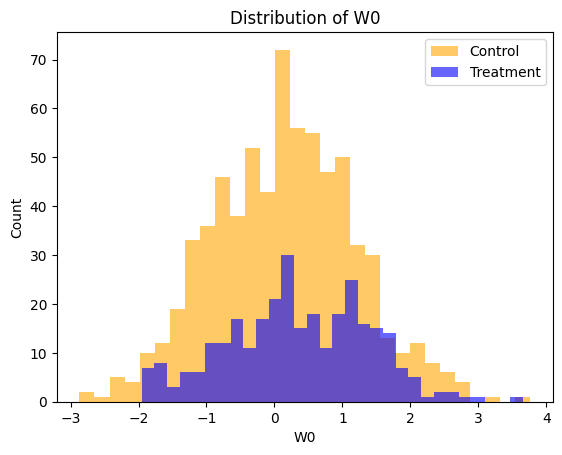

In [6]:
import matplotlib.pyplot as plt

def standardized_mean_diff(x_t, x_c):
    # SMD for continuous variable
    mu_t, mu_c = np.nanmean(x_t), np.nanmean(x_c)
    sd_pooled = np.sqrt((np.nanvar(x_t, ddof=1)+np.nanvar(x_c, ddof=1))/2)
    return (mu_t - mu_c) / (sd_pooled + 1e-12)

if df_lalonde is not None:
    tmask = df_lalonde[treatment_col] == 1
    cmask = df_lalonde[treatment_col] == 0

    print("治疗组 n =", int(tmask.sum()), "| 对照组 n =", int(cmask.sum()))

    smd_rows = []
    for v in common_causes:
        x_t, x_c = df_lalonde.loc[tmask, v], df_lalonde.loc[cmask, v]
        smd = standardized_mean_diff(x_t, x_c)
        smd_rows.append((v, smd))
    smd_df = pd.DataFrame(smd_rows, columns=["variable", "SMD"]).sort_values("variable")
    display(smd_df)

    # 对其中一个变量画直方图（先画 Control，再画 Treatment）
    var_to_plot = common_causes[0]
    plt.figure()
    plt.hist(df_lalonde.loc[cmask, var_to_plot], alpha=0.6, label="Control", bins=30, color="orange")
    plt.hist(df_lalonde.loc[tmask, var_to_plot], alpha=0.6, label="Treatment", bins=30, color="blue")
    plt.xlabel(var_to_plot)
    plt.ylabel("Count")
    plt.legend()
    plt.title(f"Distribution of {var_to_plot}")
    plt.show()
else:
    print("未能加载数据。请先安装并重试。")



## 2. 加载医学公共数据：UCI Heart Disease



### UCI Pima Indians Diabetes 数据集

#### 单元 1：加载 Pima Diabetes 数据集

In [7]:
# === 0.3.2 (替代) 加载 UCI Pima Indians Diabetes 数据集 ===
import pandas as pd

url_diabetes = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"

df_diabetes = None
try:
    df_diabetes = pd.read_csv(url_diabetes)
    print(f"已成功加载：{url_diabetes}")
    display(df_diabetes.head())
    print("形状:", df_diabetes.shape)
except Exception as e:
    print("加载失败：", e)




已成功加载：https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


形状: (768, 9)


#### 单元 2：快速体检与基础清洗（命名规范、类型、重复值）


In [8]:

# 统一列名风格，去重，检查类型
df = df_diabetes.copy()

# 列名统一为小写+下划线
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# outcome 列通常为 0/1
if "outcome" not in df.columns:
    raise ValueError("数据集中没有 'outcome' 列，请检查数据来源。")

# 去重
before = len(df)
df = df.drop_duplicates()
print(f"去重：{before} -> {len(df)} 行")

# 基本信息
print("\n=== info() ===")
print(df.info())

print("\n=== 前 5 行 ===")
display(df.head())

print("\n=== 统计特征（数值） ===")
display(df.describe())


去重：768 -> 768 行

=== info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pregnancies               768 non-null    int64  
 1   glucose                   768 non-null    int64  
 2   bloodpressure             768 non-null    int64  
 3   skinthickness             768 non-null    int64  
 4   insulin                   768 non-null    int64  
 5   bmi                       768 non-null    float64
 6   diabetespedigreefunction  768 non-null    float64
 7   age                       768 non-null    int64  
 8   outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

=== 前 5 行 ===


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



=== 统计特征（数值） ===


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### 单元 3：缺失值识别与处理（Pima 常见“0 即缺失”列）

In [9]:
import numpy as np

# 将 "0" 视作缺失的列
zero_as_na_cols = ["glucose", "bloodpressure", "skinthickness", "insulin", "bmi"]

for col in zero_as_na_cols:
    if col in df.columns:
        zero_count = (df[col] == 0).sum()
        print(f"{col}: 将 {zero_count} 个 0 视作缺失")
        df[col] = df[col].replace(0, np.nan)

print("\n=== 缺失概览（替换 0→NaN 后） ===")
display(df.isna().sum().to_frame("missing_n").T)

# 简单填补：中位数
for col in zero_as_na_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

print("\n=== 缺失处理后检查 ===")
display(df.isna().sum().to_frame("missing_n").T)


glucose: 将 5 个 0 视作缺失
bloodpressure: 将 35 个 0 视作缺失
skinthickness: 将 227 个 0 视作缺失
insulin: 将 374 个 0 视作缺失
bmi: 将 11 个 0 视作缺失

=== 缺失概览（替换 0→NaN 后） ===


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
missing_n,0,5,35,227,374,11,0,0,0



=== 缺失处理后检查 ===


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
missing_n,0,0,0,0,0,0,0,0,0


#### 单元 4：类别平衡与基本分布

Outcome 分布（0=无糖尿病, 1=糖尿病）


,count
outcome,
0,500
1,268


,percent %
outcome,
0,65.1
1,34.9


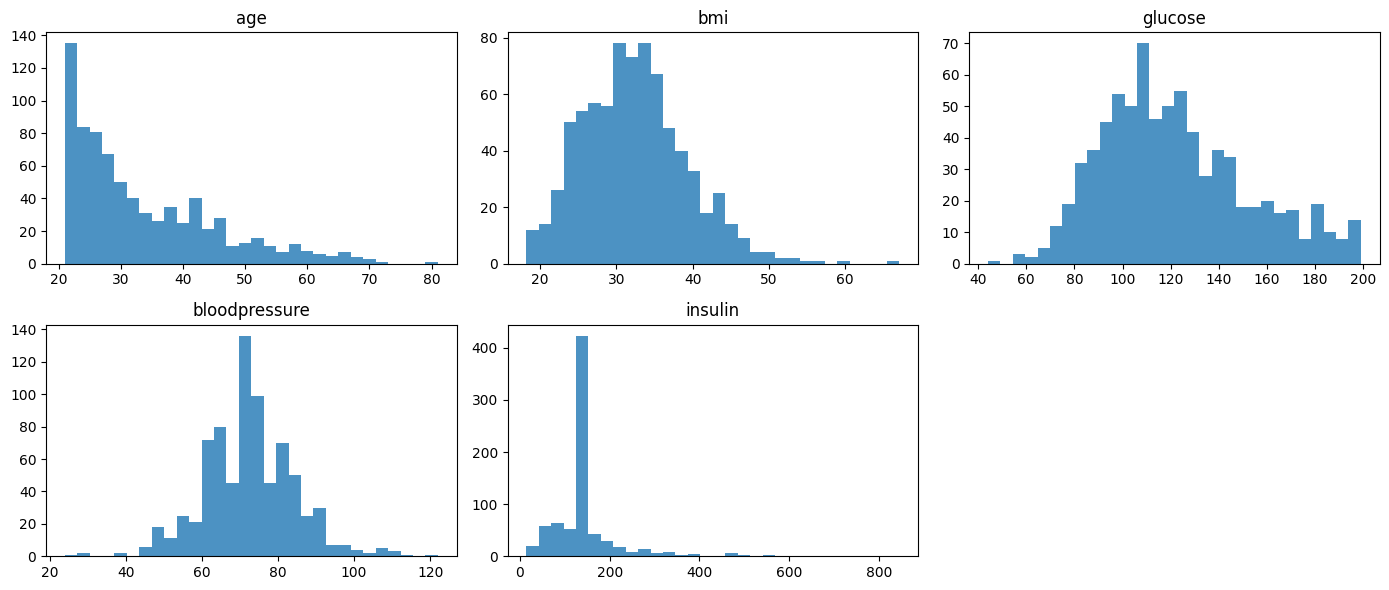

In [10]:
# 类别平衡（Outcome 作为疾病结局）
print("Outcome 分布（0=无糖尿病, 1=糖尿病）")
display(df["outcome"].value_counts().to_frame("count"))
display((df["outcome"].value_counts(normalize=True)*100).round(2).to_frame("percent %"))

# 关键变量的基本分布（直方图）
import matplotlib.pyplot as plt

key_vars = ["age", "bmi", "glucose", "bloodpressure", "insulin"]
key_vars = [v for v in key_vars if v in df.columns]

n = len(key_vars)
plt.figure(figsize=(14, 3*max(1, (n+2)//3)))
for i, v in enumerate(key_vars, 1):
    plt.subplot((n+2)//3, 3, i)
    plt.hist(df[v], bins=30, alpha=0.8)
    plt.title(v)
plt.tight_layout()
plt.show()


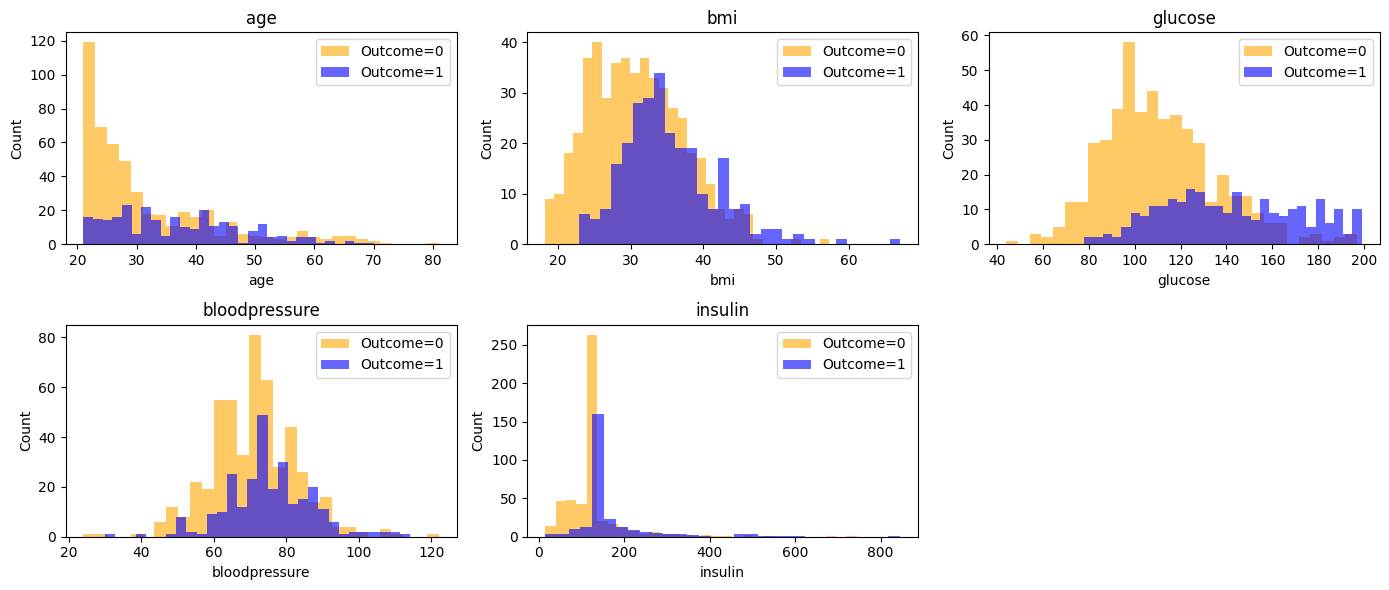

In [11]:
# === 不同 outcome 的分布对比直方图 ===
import matplotlib.pyplot as plt

# Outcome 分组掩码
mask0 = df["outcome"] == 0
mask1 = df["outcome"] == 1

n = len(key_vars)
plt.figure(figsize=(14, 3*max(1, (n+2)//3)))

for i, v in enumerate(key_vars, 1):
    plt.subplot((n+2)//3, 3, i)
    # 先画 Outcome=0（橙色），再画 Outcome=1（蓝色），避免遮挡
    plt.hist(df.loc[mask0, v], bins=30, alpha=0.6, color="orange", label="Outcome=0")
    plt.hist(df.loc[mask1, v], bins=30, alpha=0.6, color="blue", label="Outcome=1")
    plt.title(v)
    plt.xlabel(v)
    plt.ylabel("Count")
    plt.legend()

plt.tight_layout()
plt.show()


#### 单元 5：因果导向的 EDA —— 组间基线差异（以 Outcome 分组演示）

> 阶段 0 的目标是学会“按组比较、识别潜在混杂”。严格的因果分析需要真实的处理变量（干预/暴露），这里只是用 Outcome 分组演示**如何计算标准化差异（SMD）**与绘制分布图的方法（等你后续定义好真实的 treatment 后可复用）。


解释：

SMD（Standardized Mean Difference） 是衡量组间基线差异的标准化指标，绝对值越大，差异越明显。因果分析前通常要求 SMD 接近 0（如 <0.1 或 <0.2），说明经过匹配/加权后两组可比。



Outcome=1 (n1) = 268 | Outcome=0 (n0) = 500


,variable,SMD
7,age,0.519030
2,bloodpressure,0.352006
5,bmi,0.686712
6,diabetespedigreefunction,0.357600
1,glucose,1.154218
4,insulin,0.416191
0,pregnancies,0.461277
3,skinthickness,0.460095


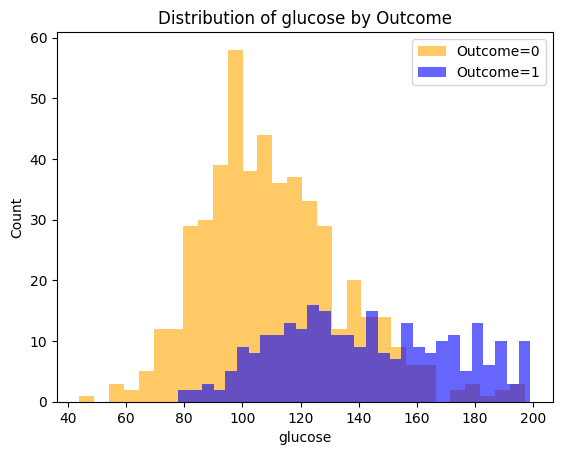

In [12]:
# 构造分组掩码（这里仅用于演示：以后替换为真实的 treatment 分组）
grp1_mask = df["outcome"] == 1  # “病例/有事件”组（示意）
grp0_mask = df["outcome"] == 0  # “对照/无事件”组（示意）

print("Outcome=1 (n1) =", int(grp1_mask.sum()), "| Outcome=0 (n0) =", int(grp0_mask.sum()))

# 计算标准化均值差（SMD）——连续变量
def standardized_mean_diff(x1, x0):
    mu1, mu0 = np.nanmean(x1), np.nanmean(x0)
    sd_pooled = np.sqrt((np.nanvar(x1, ddof=1) + np.nanvar(x0, ddof=1)) / 2)
    return (mu1 - mu0) / (sd_pooled + 1e-12)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "outcome"]  # 排除标签列

smd_rows = []
for v in num_cols:
    smd = standardized_mean_diff(df.loc[grp1_mask, v], df.loc[grp0_mask, v])
    smd_rows.append((v, smd))

smd_df = pd.DataFrame(smd_rows, columns=["variable", "SMD"]).sort_values("variable")
display(smd_df)

# 可视化一个代表性变量的组间分布（先画对照，再画病例，避免遮挡）
var_to_plot = "glucose" if "glucose" in df.columns else num_cols[0]
plt.figure()
plt.hist(df.loc[grp0_mask, var_to_plot], alpha=0.6, label="Outcome=0", bins=30, color="orange")
plt.hist(df.loc[grp1_mask, var_to_plot], alpha=0.6, label="Outcome=1", bins=30, color="blue")
plt.xlabel(var_to_plot); plt.ylabel("Count"); plt.legend(); plt.title(f"Distribution of {var_to_plot} by Outcome")
plt.show()


#### 单元 6：（可选）变量相关性与多重共线性初筛

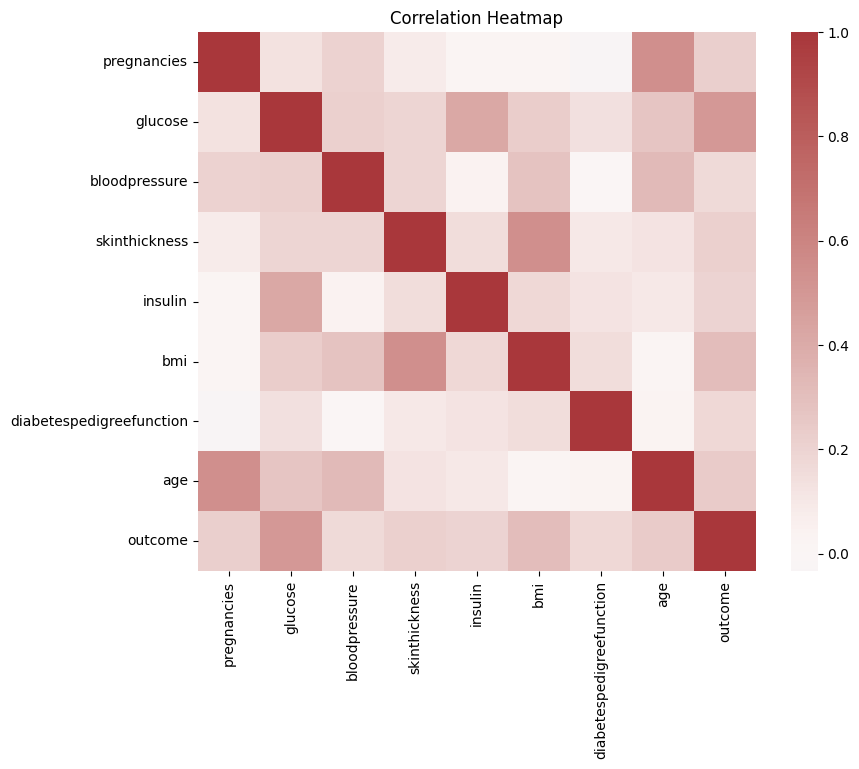

In [13]:
# 数值变量相关性热力图（用于识别潜在共线性，后续做建模时注意）
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

corr = df[num_cols + ["outcome"]].corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=False, cmap="vlag", center=0)
plt.title("Correlation Heatmap")
plt.show()


#### 单元 7：导出清洗后的数据，便于后续阶段复用

In [14]:
# 保存清洗后的数据（供后续阶段 1/2/3 使用）
save_path = "pima_diabetes_clean.csv"
df.to_csv(save_path, index=False)
print(f"已保存清洗后的数据到: {save_path}")


已保存清洗后的数据到: pima_diabetes_clean.csv


### UCI Breast Cancer 数据集

#### 单元 1：加载数据（sklearn 自带，稳定可靠）

In [15]:
# === 加载 UCI Breast Cancer 数据集（sklearn 自带） ===
from sklearn.datasets import load_breast_cancer
import pandas as pd

cancer = load_breast_cancer(as_frame=True)
df_bc = cancer.frame.copy()   # 包含特征 + target 列
print("已成功加载乳腺癌数据集")
print("feature 数量：", len(cancer.feature_names))
print("target 名称：", cancer.target_names.tolist(), "（0=恶性 malignant, 1=良性 benign）")

display(df_bc.head())
print("形状:", df_bc.shape)


已成功加载乳腺癌数据集
feature 数量： 30
target 名称： ['malignant', 'benign'] （0=恶性 malignant, 1=良性 benign）


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


形状: (569, 31)


#### 单元 2：基础体检与清洗（命名统一、去重、类型检查）

In [16]:
# 复制为 df，统一列名风格
df = df_bc.copy()
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# 确认标签列
if "target" not in df.columns:
    raise ValueError("未找到 'target' 列。")

# 去重
before = len(df)
df = df.drop_duplicates()
print(f"去重：{before} -> {len(df)} 行")

# 快速信息
print("\n=== info() ===")
print(df.info())

print("\n=== 前 5 行 ===")
display(df.head())

print("\n=== 基本统计 ===")
display(df.describe())


去重：569 -> 569 行

=== info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_radius              569 non-null    float64
 1   mean_texture             569 non-null    float64
 2   mean_perimeter           569 non-null    float64
 3   mean_area                569 non-null    float64
 4   mean_smoothness          569 non-null    float64
 5   mean_compactness         569 non-null    float64
 6   mean_concavity           569 non-null    float64
 7   mean_concave_points      569 non-null    float64
 8   mean_symmetry            569 non-null    float64
 9   mean_fractal_dimension   569 non-null    float64
 10  radius_error             569 non-null    float64
 11  texture_error            569 non-null    float64
 12  perimeter_error          569 non-null    float64
 13  area_error               569 non-null    float64

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0



=== 基本统计 ===


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


#### 单元 3：设置绘图风格（与方案 1 不同的视觉风格

已切换 matplotlib 风格为：ggplot


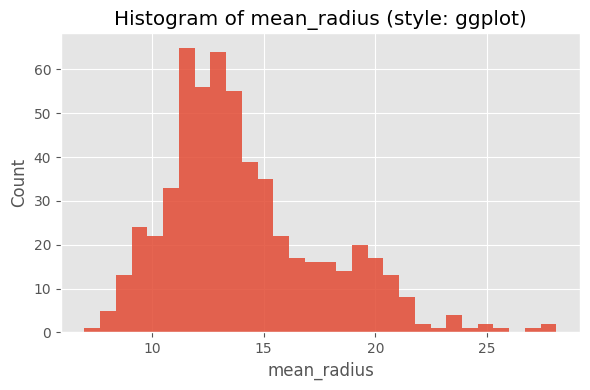

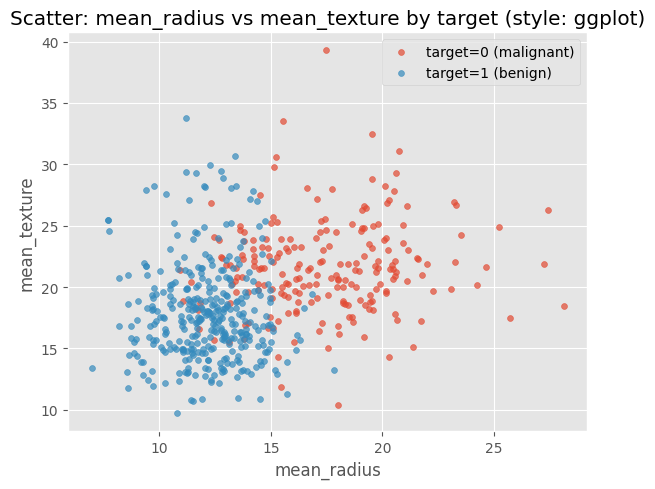

In [17]:
# === 单元 3：设置绘图风格（并绘制示例图以确认风格生效） ===
import matplotlib.pyplot as plt
import numpy as np

# 可选风格举例：'ggplot', 'seaborn-v0_8-whitegrid', 'bmh', 'fivethirtyeight',
# 'tableau-colorblind10', 'Solarize_Light2', 'classic', 等
def use_style(name='ggplot'):
    """一键切换 matplotlib 绘图风格"""
    try:
        plt.style.use(name)
        print(f"已切换 matplotlib 风格为：{name}")
    except Exception as e:
        print("切换风格失败：", e)

# 1) 设置默认风格为 ggplot（与方案1不同）
use_style('ggplot')

# 2) 选择示例变量（保证存在）
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "mean_radius" in df.columns:
    var1 = "mean_radius"
else:
    var1 = num_cols[0]  # 兜底：第一个数值列

if "mean_texture" in df.columns and "mean_texture" != var1:
    var2 = "mean_texture"
else:
    # 找一个与 var1 不同的数值列做散点图
    var2 = next((c for c in num_cols if c != var1), None)

# 3) 示例图 A：直方图（单变量分布）
plt.figure(figsize=(6,4))
plt.hist(df[var1], bins=30, alpha=0.85)
plt.title(f"Histogram of {var1} (style: ggplot)")
plt.xlabel(var1)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4) 示例图 B：分组散点图（按 target 分组；0=恶性, 1=良性）
if var2 is not None and "target" in df.columns:
    grp0 = df["target"] == 0  # 恶性
    grp1 = df["target"] == 1  # 良性

    plt.figure(figsize=(6,5))
    plt.scatter(df.loc[grp0, var1], df.loc[grp0, var2], s=18, alpha=0.7, label="target=0 (malignant)")
    plt.scatter(df.loc[grp1, var1], df.loc[grp1, var2], s=18, alpha=0.7, label="target=1 (benign)")
    plt.title(f"Scatter: {var1} vs {var2} by target (style: ggplot)")
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("未能找到用于散点图的第二个数值变量或 'target' 列，已跳过散点图示例。")

# 5) （可选）想尝试其它风格时，取消注释下面两行之一再运行：
# use_style('seaborn-v0_8-whitegrid')
# use_style('fivethirtyeight')
# 然后重复上面的绘图代码块即可对比不同风格的效果。


#### 单元 4：类别平衡 & 基本分布

target 分布（0=恶性, 1=良性）


,count
target,
1,357
0,212


,percent %
target,
1,62.74
0,37.26


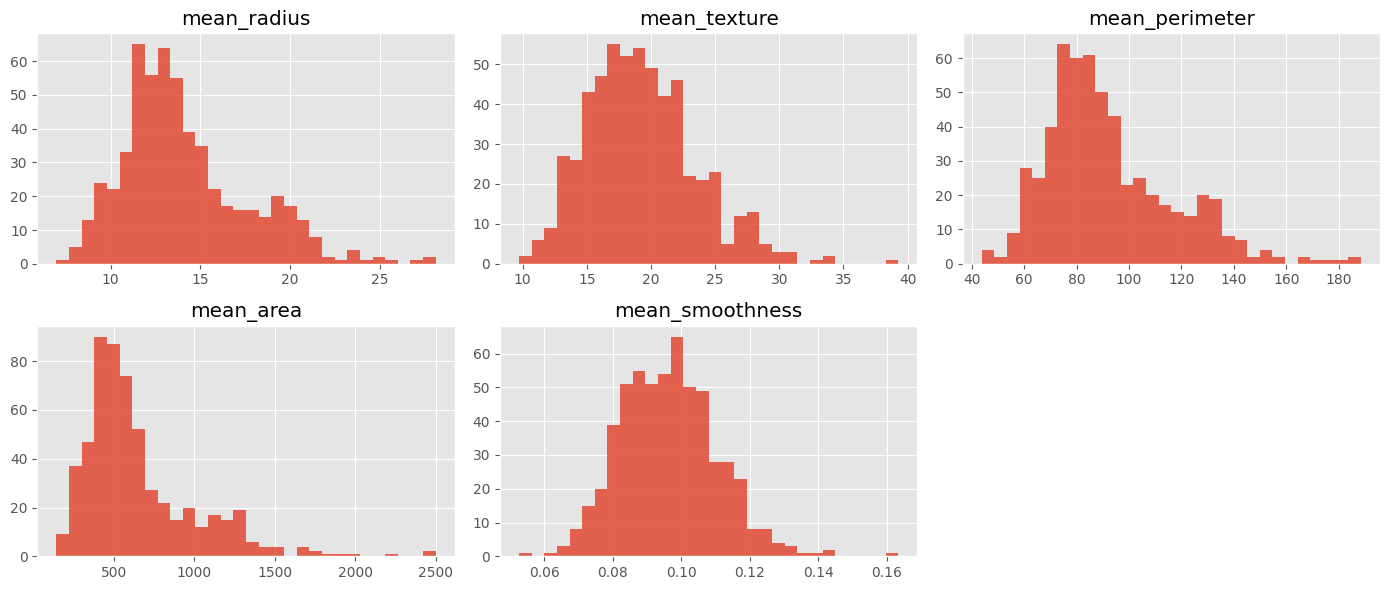

In [18]:
# target: 0 = malignant(恶性), 1 = benign(良性)
print("target 分布（0=恶性, 1=良性）")
display(df["target"].value_counts().to_frame("count"))
display((df["target"].value_counts(normalize=True)*100).round(2).to_frame("percent %"))

# 关键特征分布
key_vars = ["mean_radius", "mean_texture", "mean_perimeter", "mean_area", "mean_smoothness"]
key_vars = [v for v in key_vars if v in df.columns]

import numpy as np
n = len(key_vars)
plt.figure(figsize=(14, 3*max(1, (n+2)//3)))
for i, v in enumerate(key_vars, 1):
    plt.subplot((n+2)//3, 3, i)
    plt.hist(df[v], bins=30, alpha=0.85)
    plt.title(v)
plt.tight_layout()
plt.show()


In [ ]:
# === 不同 outcome 的分布对比直方图 ===
import matplotlib.pyplot as plt

# Outcome 分组掩码
mask0 = df["outcome"] == 0
mask1 = df["outcome"] == 1

n = len(key_vars)
plt.figure(figsize=(14, 3*max(1, (n+2)//3)))

for i, v in enumerate(key_vars, 1):
    plt.subplot((n+2)//3, 3, i)
    # 先画 Outcome=0（橙色），再画 Outcome=1（蓝色），避免遮挡
    plt.hist(df.loc[mask0, v], bins=30, alpha=0.6, color="orange", label="Outcome=0")
    plt.hist(df.loc[mask1, v], bins=30, alpha=0.6, color="blue", label="Outcome=1")
    plt.title(v)
    plt.xlabel(v)
    plt.ylabel("Count")
    plt.legend()

plt.tight_layout()
plt.show()


#### 单元 5：因果导向 EDA —— 组间基线差异（以 target 分组演示）

良性(1) n = 357 | 恶性(0) n = 212


,variable,SMD
13,area_error,-1.175762
15,compactness_error,-0.623187
17,concave_points_error,-0.926790
16,concavity_error,-0.568474
19,fractal_dimension_error,-0.168526
3,mean_area,-1.861605
5,mean_compactness,-1.446075
7,mean_concave_points,-2.325082
6,mean_concavity,-1.871437
9,mean_fractal_dimension,0.026115


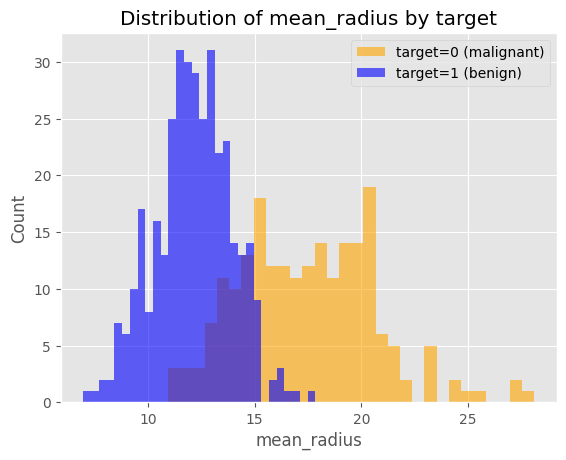

In [19]:
# 分组掩码（演示用：0=恶性，1=良性）
grp1_mask = df["target"] == 1   # 良性
grp0_mask = df["target"] == 0   # 恶性

print("良性(1) n =", int(grp1_mask.sum()), "| 恶性(0) n =", int(grp0_mask.sum()))

# 连续变量 SMD
def standardized_mean_diff(x1, x0):
    mu1, mu0 = np.nanmean(x1), np.nanmean(x0)
    sd_pooled = np.sqrt((np.nanvar(x1, ddof=1) + np.nanvar(x0, ddof=1)) / 2)
    return (mu1 - mu0) / (sd_pooled + 1e-12)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "target"]

smd_rows = []
for v in num_cols:
    smd = standardized_mean_diff(df.loc[grp1_mask, v], df.loc[grp0_mask, v])
    smd_rows.append((v, smd))

smd_df = pd.DataFrame(smd_rows, columns=["variable", "SMD"]).sort_values("variable")
display(smd_df)

# 可视化一个代表性变量（先画“恶性=0/对照”橙色，再画“良性=1/病例”蓝色，避免遮挡）
var_to_plot = "mean_radius" if "mean_radius" in df.columns else num_cols[0]
plt.figure()
plt.hist(df.loc[grp0_mask, var_to_plot], alpha=0.6, label="target=0 (malignant)", bins=30, color="orange")
plt.hist(df.loc[grp1_mask, var_to_plot], alpha=0.6, label="target=1 (benign)",    bins=30, color="blue")
plt.xlabel(var_to_plot); plt.ylabel("Count"); plt.legend(); plt.title(f"Distribution of {var_to_plot} by target")
plt.show()


#### 单元 6：相关性热力图（辅助识别潜在共线性）

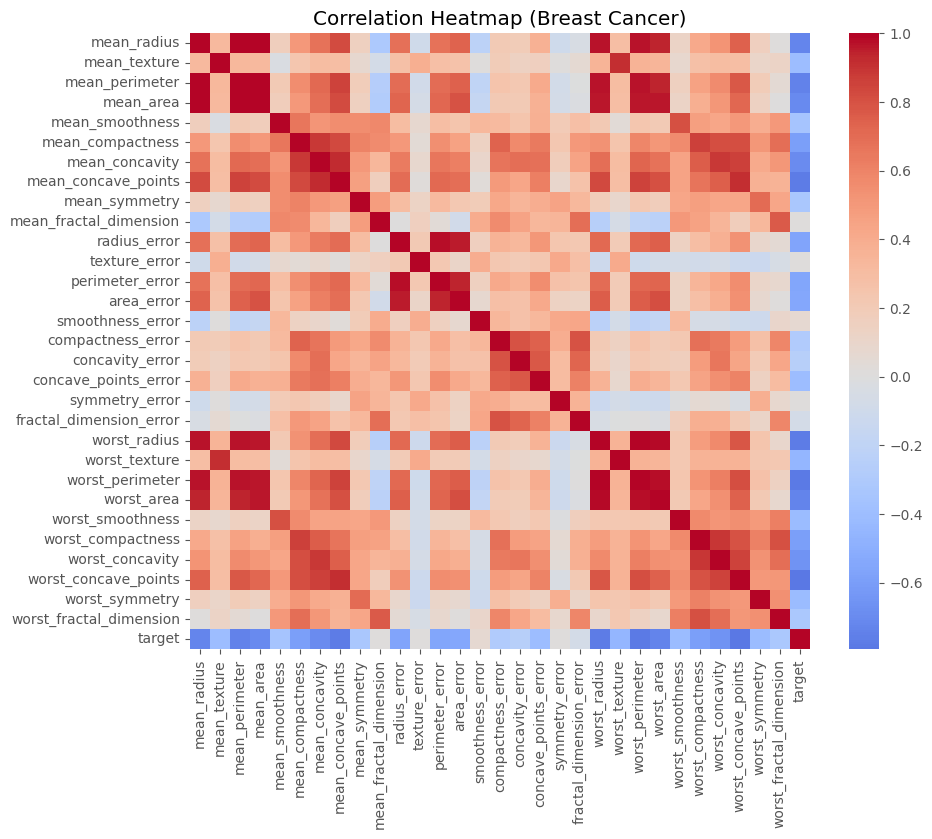

In [20]:
import seaborn as sns

corr = df[num_cols + ["target"]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, square=False)
plt.title("Correlation Heatmap (Breast Cancer)")
plt.show()


#### 单元 7：导出清洗后的数据（供后续阶段使用）

In [21]:
save_path = "breast_cancer_clean.csv"
df.to_csv(save_path, index=False)
print(f"已保存清洗后的数据到: {save_path}")


已保存清洗后的数据到: breast_cancer_clean.csv



## 3. 因果视角下的 EDA 清单（医疗版）

- **治疗/暴露定义是否明确？**（例：是否使用某药、是否接受某项手术）  
- **结局定义是否明确？**（例：28 天死亡率、住院再入院、并发症发生）  
- **时间顺序明确吗？**（确保暴露先于结局）  
- **混杂因子列出了吗？**（年龄、性别、基线疾病、合并用药、入院严重度评分等）  
- **基线平衡如何？**（标准化差异 SMD 是否 > 0.1/0.2）  
- **缺失数据机制？**（MCAR/MAR/MNAR，计划如何填补或建模）  
- **极端值/异常值处理？**（winsorize、对数变换、分位数裁剪）  
- **抽样/选择偏倚迹象？**（纳入排除标准是否合理；外推性如何）
